# HoVerNet Post Processing 

In [1]:
%matplotlib widget

In [2]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

In [3]:
# MODEL

from src.model.architectures.graph_construction.hover_net import HoVerNet

checkpoint_path = os.path.join(parent,"experiments","checkpoints","HoVerNet_MoNuSeg Test 4 - No Checkpoint.ckpt")
args = {"RESNET_SIZE":50, "START_LR":0}
model = HoVerNet.load_from_checkpoint(checkpoint_path,**args)

In [4]:
# TRANSFORMS
from torchvision.transforms import Compose,RandomApply
from src.transforms.image_processing.augmentation import *


scale_modes = {"image": InterpolationMode.BILINEAR, "semantic_mask": InterpolationMode.NEAREST, "instance_map": InterpolationMode.NEAREST}
transforms = Compose([


        RandomCrop(size=(64, 64)),
        Normalize(
                {"image": [0.6441, 0.4474, 0.6039]},
                {"image": [0.1892, 0.1922, 0.1535]})
        ]) 

In [5]:
# DATA

from src.datasets.MoNuSeg import MoNuSeg
val_folder=  os.path.join(parent,"data","processed","MoNuSeg_TRAIN")
dataset_val = MoNuSeg(val_folder,transform=transforms)

In [6]:
# SAMPLE
from tqdm import tqdm
sample = [dataset_val[i] for i in tqdm(range(5))]

100%|██████████| 5/5 [00:00<00:00,  7.29it/s]


In [7]:
# PREDICTIONS

model.eval()
model.cpu()
predictions = []
for item in tqdm(sample,total = len(sample)):
    sm,hv = model(item["image"].unsqueeze(0))
    sm = sm.squeeze().detach().cpu()
    hv = hv.squeeze().detach().cpu()
    predictions.append({"semantic_mask":sm,"hover_map":hv,"semantic_mask_hard":(sm>0.5).int()})


100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


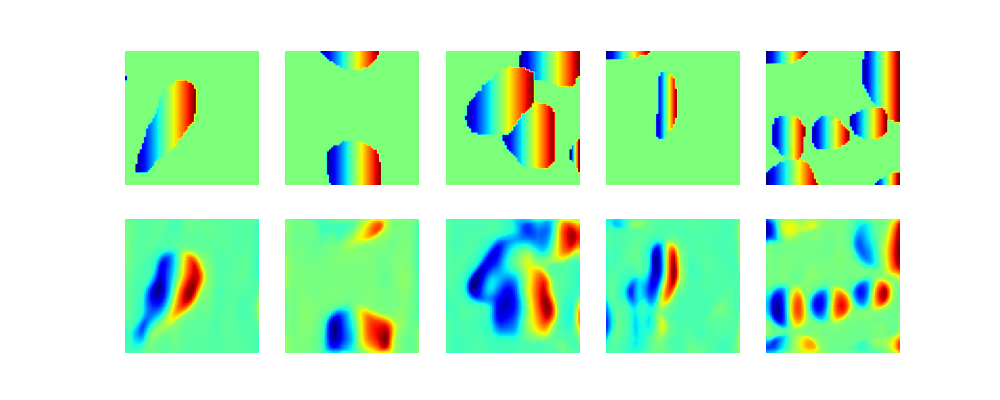

In [8]:
# DISPLAY
from src.vizualizations.image_viz import plot_images

h_maps = [img["hover_map"][0] for img in sample] + [img["hover_map"][0] for img in predictions]
plot_images(h_maps,(2,5),"jet")

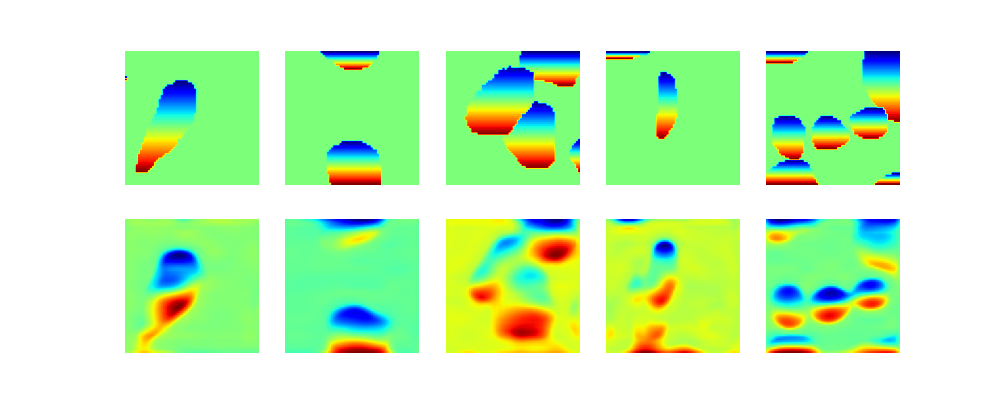

In [9]:
v_maps = [img["hover_map"][1] for img in sample] + [img["hover_map"][1] for img in predictions]
plot_images(v_maps,(2,5),"jet")

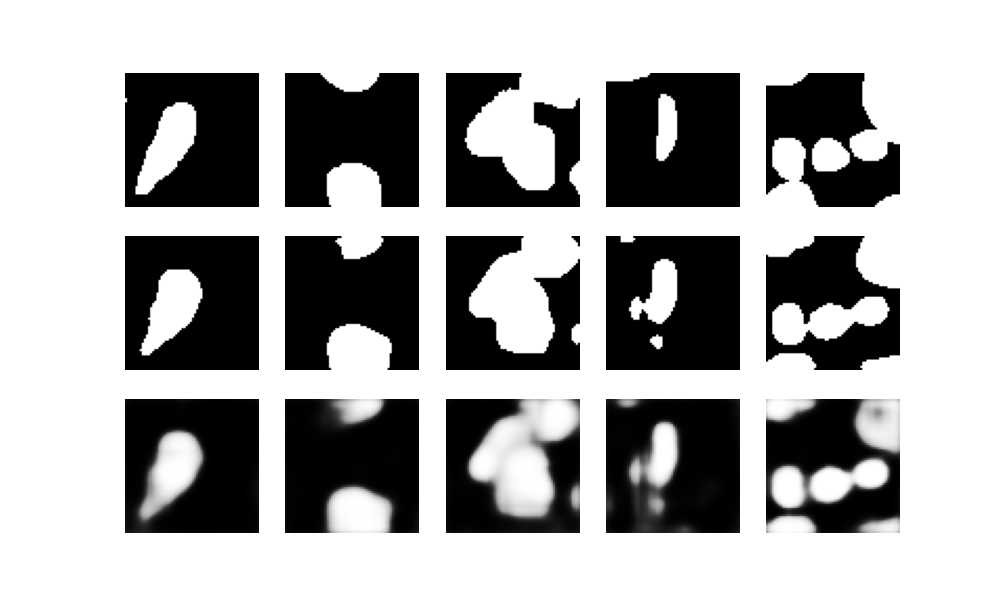

In [10]:
sms = [img["semantic_mask"].squeeze() for img in sample] + [img["semantic_mask_hard"] for img in predictions] + [img["semantic_mask"] for img in predictions]
plot_images(sms,(3,5),"gray")

# Filters

In [61]:
from PIL import ImageFilter
from torchvision.transforms import ToPILImage
from torch.nn.functional import conv2d
from torch import Tensor

sobel_x = Tensor([[-1,0,1],[-2,0,2],[-1,0,1]]).unsqueeze(0).unsqueeze(0).float()/2
sobel_y = Tensor([[1,2,1],[0,0,0],[-1,-2,-1]]).unsqueeze(0).unsqueeze(0).float()/2

def sobel(img):
    img = img.unsqueeze(0).unsqueeze(0)
    img_x = conv2d(img,sobel_x,stride=1,padding=1)
    img_y = conv2d(img,sobel_y,stride=1,padding=1)
    return img_x,img_y

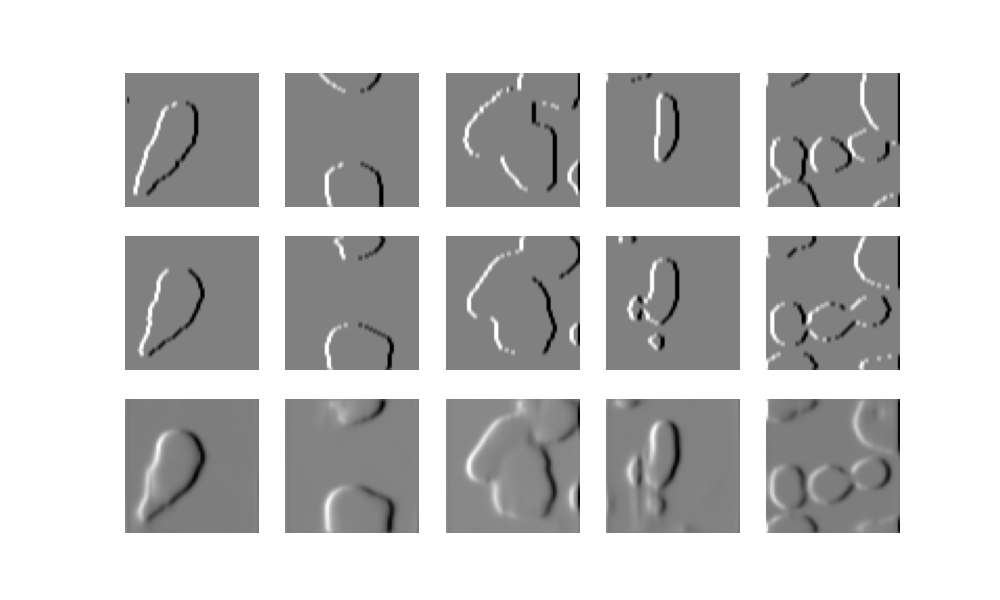

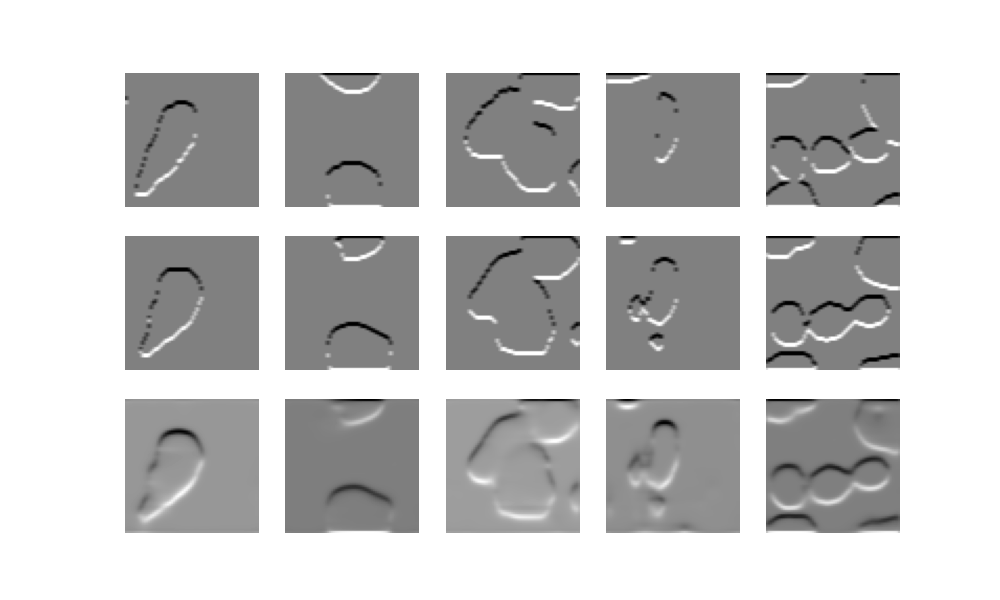

In [62]:
sms_sobel = [sobel(img.float()) for img in sms]
plot_images([img[0].squeeze() for img in sms_sobel],(3,5),"gray")
plot_images([img[1].squeeze() for img in sms_sobel],(3,5),"gray")

# TODO - NOTE THAT YOU NEED TO REALLY SPECIFY IN API USAGE


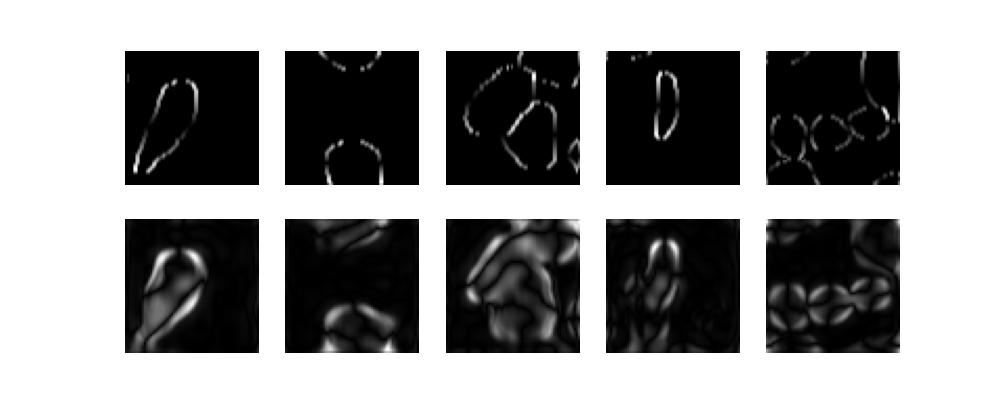

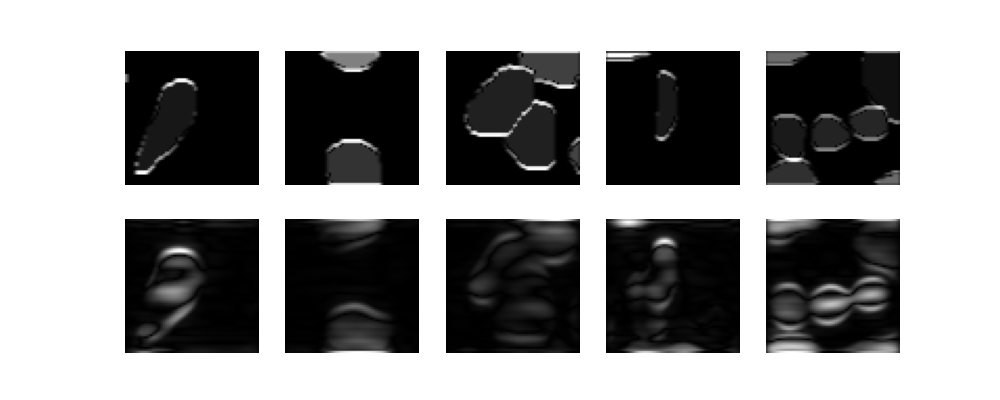

In [66]:
v_maps_sobel = [sobel(img.float()) for img in v_maps]
plot_images([img[0].squeeze().abs() for img in v_maps_sobel],(2,5),"gray")
plot_images([img[1].squeeze().abs() for img in v_maps_sobel],(2,5),"gray")

In [67]:
def S(hv_map):
    hv_horiz,hv_vert = hv_map
    hpx = sobel(hv_horiz.float())[0].abs()
    hpy = sobel(hv_vert.float())[1].abs()
    return torch.maximum(hpx,hpy).squeeze()

TypeError: Invalid shape (1, 1, 64, 64) for image data

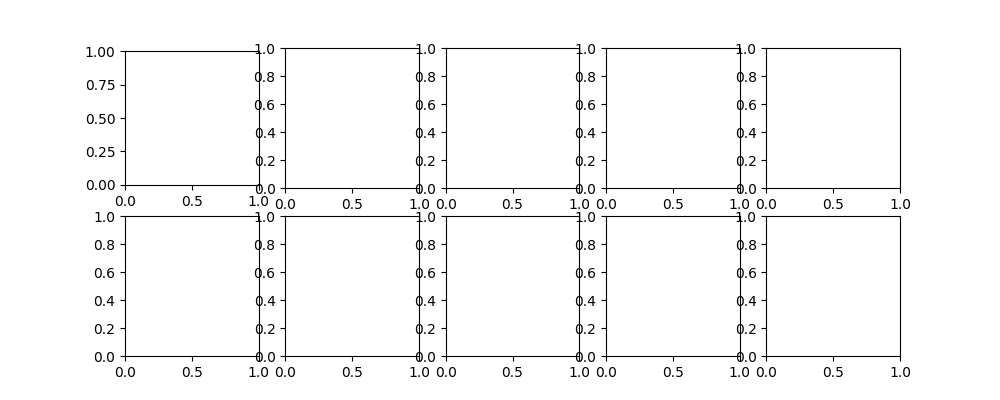

In [69]:
importance = [S(img) for img in zip(h_maps,v_maps)]
plot_images(importance,(2,5),"gray")